# Multi-panel plotting of all galaxies and one type of image, or one galaxy and several types of images.

In [2]:
import numpy as np
import edge_pydb
edge_pydb.util.add_from_dir('/Volumes/Scratch2/tonywong/EDGE/pybase/', max_depth=0, copy=False)
print(edge_pydb.__path__)
from edge_pydb import EdgeTable
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from edge_pydb.plotting import dotpatch
from edge_pydb.conversion import sfr_ha
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

WARNING! No sudo permission, take care, will break
Add file cospec_iram.csv
Add file edge.cocube_smo7.hdf5
Add file edge.comom_smo7.hdf5
Add file edge.pipe3d.hdf5
Add file edge178_leda.csv
Add file edge_allpix.comom_smo7.hdf5
Add file edge_allpix.pipe3d.hdf5
Add file edge_coflux_iram.csv
Add file edge_cospec_e20.csv
Add file edge_cospec_natv.csv
Add file edge_cospec_smo7.csv
Add file edge_hispectra.csv
Add file edgealma_hiflux.csv
Add file edgealma_hispectra.csv
WARNING! The location of this file will be saved runtime only
['/Users/tonywong/Work/bin/site-packages/edge_pydb']


In [3]:
sspcols = ['Name','ix','iy','medflx_ssp_sm','e_medflx_ssp_sm','age_lwt_sm','e_age_lwt_sm',
           'vdisp_ssp_sm','e_vdisp_ssp_sm','sigstar_sm','sigstar_Avcor_sm']
fluxcols = ['Name','ix','iy','flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm',
            'e_flux_Hbeta_sm','AHa_flux_sigsfr_sm','flux_sigsfr0_sm','flux_sigsfr_sm','e_flux_sigsfr_sm']
cocols = ['Name','ix','iy','mom0_12','emom0_12','mom2_12','emom2_12','sigmol','e_sigmol']

try: 
    fluxtab = EdgeTable('edge.pipe3d.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('edge.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('edge.comom_smo7.hdf5', path='dil', cols=cocols)
    print('Working on full EDGE database')
except:
    print('Cannot locate EDGE database files')

# consolidate the tables
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
print(fluxtab.colnames)

Working on full EDGE database
['Name', 'ix', 'iy', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'e_flux_Hbeta_sm', 'AHa_flux_sigsfr_sm', 'flux_sigsfr0_sm', 'flux_sigsfr_sm', 'e_flux_sigsfr_sm', 'medflx_ssp_sm', 'e_medflx_ssp_sm', 'age_lwt_sm', 'e_age_lwt_sm', 'vdisp_ssp_sm', 'e_vdisp_ssp_sm', 'sigstar_sm', 'sigstar_Avcor_sm', 'mom0_12', 'emom0_12', 'mom2_12', 'emom2_12', 'sigmol', 'e_sigmol']


In [4]:
# Prepare a patch collection for a dotplot
def dotpatch(x, y, colors, size=1, vmin=None, vmax=None, cmap='jet'):

    patches = []
    for x1, y1 in zip(x,y):
        circle = Circle((x1, y1), size)
        patches.append(circle)

    p = PatchCollection(patches, cmap=cmap)
    p.set_array(np.array(colors))
    if vmax is None:
        vmax = np.nanmax(colors)
    if vmin is None:
        vmin = np.nanmin(colors)

    p.set_clim([vmin, vmax])
    xymin = np.min([x.min(),y.min()])
    xymax = np.max([x.max(),y.max()])

    return p, xymin, xymax

In [5]:
#Non-dotpatch image
def EdgePlot(x, y, colors, vmin=None, vmax=None):
    data=colors
    squarenum=len(np.unique(y))
    imgdata=np.reshape(data,[squarenum,squarenum],order='F')
    if vmax is None:
        vmax = np.nanmax(colors)
    if vmin is None:
        vmin = np.nanmin(colors)
    
    xymin = np.min([x.min(),y.min()])
    xymax = np.max([x.max(),y.max()])
    
    return imgdata

In [6]:
def implots(gallist=None, vmax=-1, column='flux_Halpha_sm', 
            xymin=21, xymax=115, pdfname=None):

    nx=8
    ny=6
    pages = int(np.ceil(float(len(gallist)) / (nx*ny)))
    if pdfname is not None:
        pp = PdfPages(outname)

    for num in range(0,pages):
        aa = nx*ny*num
        bb = nx*ny+aa
        thispage = gallist[aa:bb]
        fig = plt.figure(figsize=(20,14))
        for i in range(0,len(thispage)):
            gname = thispage[i]
            #print("Plotting", gname)
            ax = plt.subplot(ny,nx,i+1)
            galtab = fluxtab['Name'] == gname

            if vmax > 0:
                patch, pmin, pmax = dotpatch(fluxtab[galtab]['ix'], fluxtab[galtab]['iy'], 
                                           fluxtab[galtab][column],vmin=0,vmax=vmax)
            else:
                patch, pmin, pmax = dotpatch(fluxtab[galtab]['ix'], fluxtab[galtab]['iy'], 
                                           fluxtab[galtab][column])        
            im = ax.add_collection(patch)

            if xymin is not None:
                pltmin = xymin
            else:
                pltmin = pmin
            if xymax is not None:
                pltmax = xymax
            else:
                pltmax = pmax
            ax.set_xlim([pltmin,pltmax])
            ax.set_ylim([pltmin,pltmax])
            ax.set_aspect('equal')
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            plt.text(0.04,0.9,gname,ha='left',va='center',transform=ax.transAxes,
               bbox=dict(facecolor='white', edgecolor='none', pad=1))
        fig.subplots_adjust(hspace=0.05)
        fig.subplots_adjust(wspace=0.05)
        if pdfname is not None:
            pp.savefig(bbox_inches = 'tight', pad_inches=0.1)
            plt.close()
        else:
            plt.show()
    if pdfname is not None:
        d = pp.infodict()
        d['Title'] = 'EDGE Gallery'
        d['Author'] = 'Tony Wong'
        d['CreationDate'] = datetime.datetime.today()
        pp.close()
    return

In [7]:
def test_implots(gallist=None, vmax=-1, column='flux_Halpha_sm', 
            xymin=21, xymax=115, pdfname=None, map_style='jet'):

    nx=8
    ny=6
    pages = int(np.ceil(float(len(gallist)) / (nx*ny)))
    if pdfname is not None:
        pp = PdfPages(outname)

    for num in range(0,pages):
        aa = nx*ny*num
        bb = nx*ny+aa
        thispage = gallist[aa:bb]
        fig = plt.figure(figsize=(20,14))
        for i in range(0,len(thispage)):
            gname = thispage[i]
            #print("Plotting", gname)
            ax = plt.subplot(ny,nx,i+1)
            galtab = fluxtab['Name'] == gname

            if vmax > 0:
                patch = EdgePlot(fluxtab[galtab]['ix'], fluxtab[galtab]['iy'], 
                                           fluxtab[galtab][column],vmin=0,vmax=vmax)
            else:
                patch = EdgePlot(fluxtab[galtab]['ix'], fluxtab[galtab]['iy'], 
                                           fluxtab[galtab][column])        
            im = ax.imshow(patch,origin='lower',cmap=map_style)

#             if pmin is not None:
#                 pltmin = pmin
#             else:
#                 pltmin = xymin
#             if pmax is not None:
#                 pltmax = pmax
#             else:
#                 pltmax = xymax
#             ax.set_xlim([pltmin,pltmax])
#             ax.set_ylim([pltmin,pltmax])
            ax.set_aspect('equal')
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            plt.text(0.04,0.9,gname,ha='left',va='center',transform=ax.transAxes,
               bbox=dict(facecolor='white', edgecolor='none', pad=1))
        fig.subplots_adjust(hspace=0.05)
        fig.subplots_adjust(wspace=0.05)
        if pdfname is not None:
            pp.savefig(bbox_inches = 'tight', pad_inches=0.1)
            plt.close()
        else:
            plt.show()
    if pdfname is not None:
        d = pp.infodict()
        d['Title'] = 'EDGE Gallery'
        d['Author'] = 'Tony Wong'
        d['CreationDate'] = datetime.datetime.today()
        pp.close()
    return

In [8]:
gallist = list(np.unique(fluxtab['Name']))
print(gallist)

['ARP220', 'IC0480', 'IC0540', 'IC0944', 'IC1151', 'IC1199', 'IC1683', 'IC2247', 'IC2487', 'IC4566', 'IC5376', 'NGC0444', 'NGC0447', 'NGC0477', 'NGC0496', 'NGC0523', 'NGC0528', 'NGC0551', 'NGC1167', 'NGC2253', 'NGC2347', 'NGC2410', 'NGC2480', 'NGC2487', 'NGC2623', 'NGC2639', 'NGC2730', 'NGC2880', 'NGC2906', 'NGC2916', 'NGC2918', 'NGC3303', 'NGC3381', 'NGC3687', 'NGC3811', 'NGC3815', 'NGC3994', 'NGC4047', 'NGC4149', 'NGC4185', 'NGC4210', 'NGC4211NED02', 'NGC4470', 'NGC4644', 'NGC4676A', 'NGC4711', 'NGC4961', 'NGC5000', 'NGC5016', 'NGC5056', 'NGC5205', 'NGC5218', 'NGC5394', 'NGC5406', 'NGC5480', 'NGC5485', 'NGC5520', 'NGC5614', 'NGC5633', 'NGC5657', 'NGC5682', 'NGC5732', 'NGC5784', 'NGC5876', 'NGC5908', 'NGC5930', 'NGC5934', 'NGC5947', 'NGC5953', 'NGC5980', 'NGC6004', 'NGC6021', 'NGC6027', 'NGC6060', 'NGC6063', 'NGC6081', 'NGC6125', 'NGC6146', 'NGC6155', 'NGC6168', 'NGC6186', 'NGC6301', 'NGC6310', 'NGC6314', 'NGC6361', 'NGC6394', 'NGC6478', 'NGC7738', 'NGC7819', 'UGC00809', 'UGC03253', '

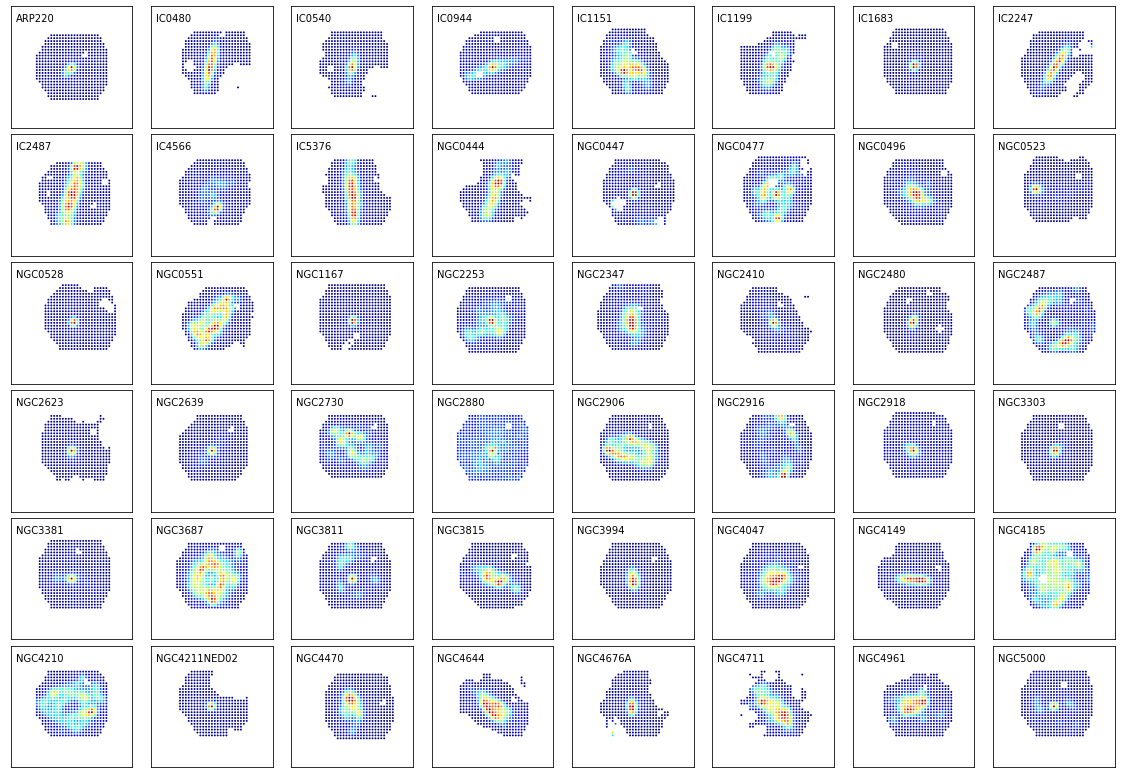

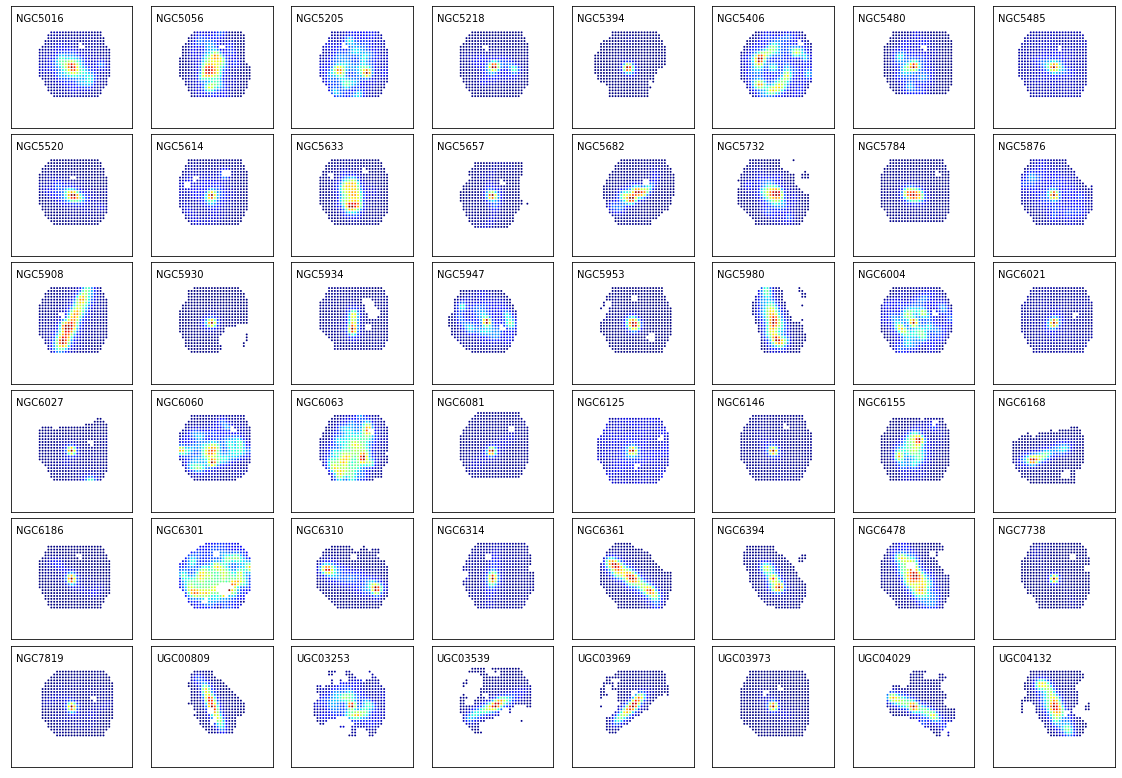

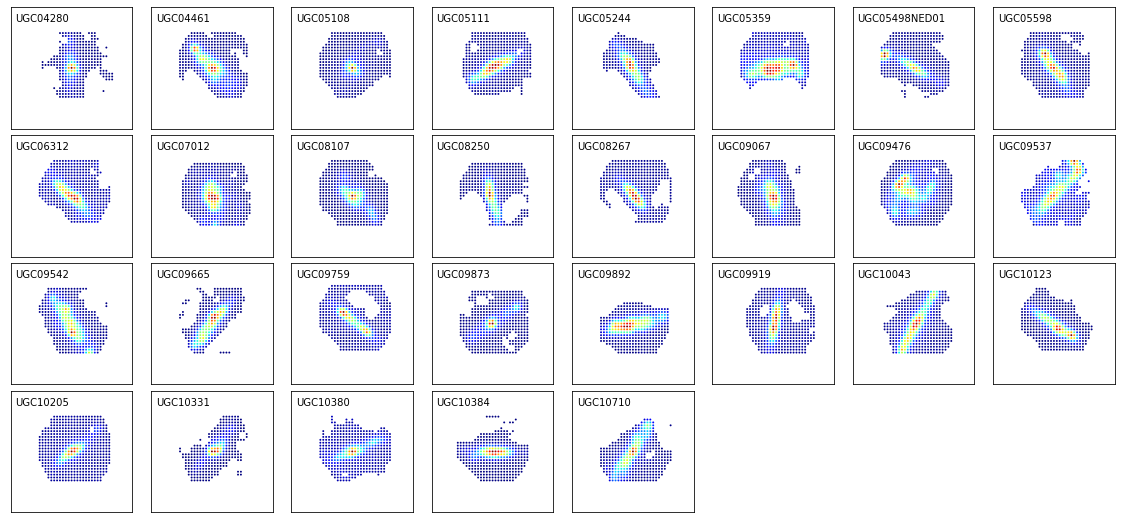

In [9]:
gallist = list(np.unique(fluxtab['Name']))
implots(gallist=gallist, xymin=None, xymax=None)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN axis encountered
  if sys.path[0] == '':
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: All-NaN axis encountered
  


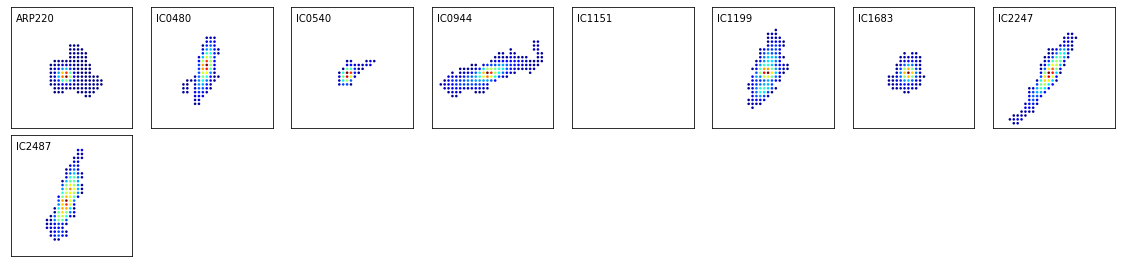

In [10]:
gallist = list(np.unique(fluxtab['Name']))[:9]
implots(gallist=gallist, column='mom0_12')

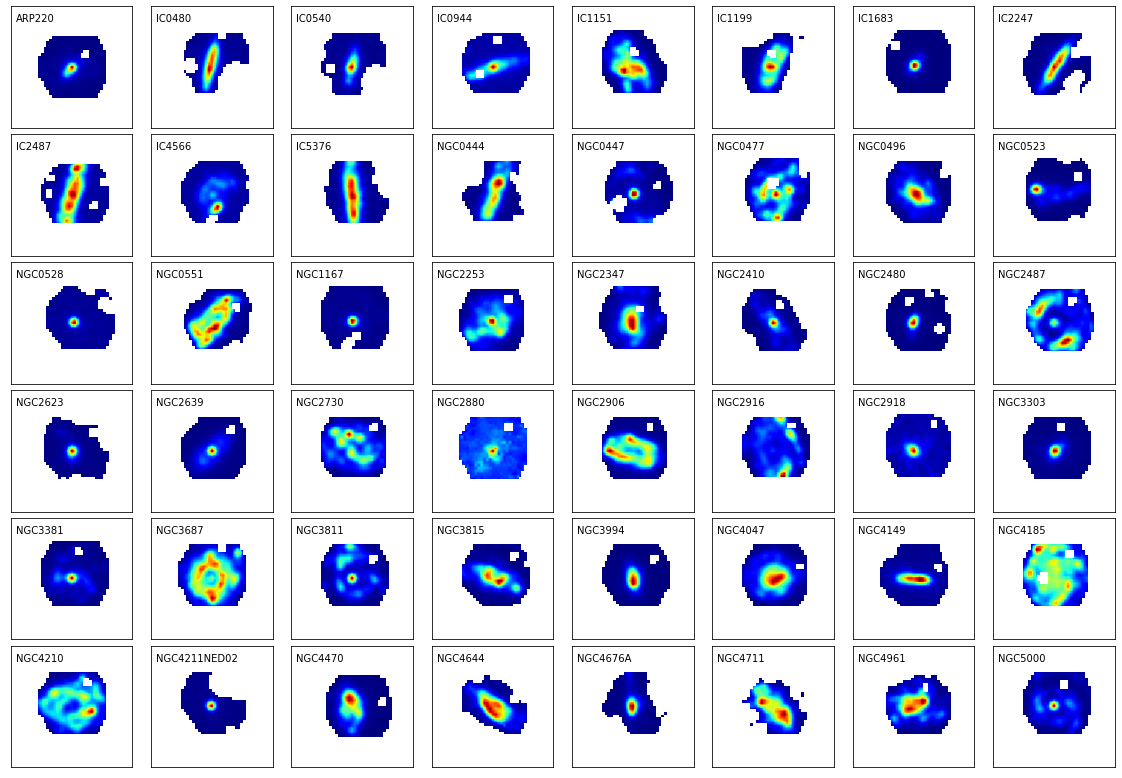

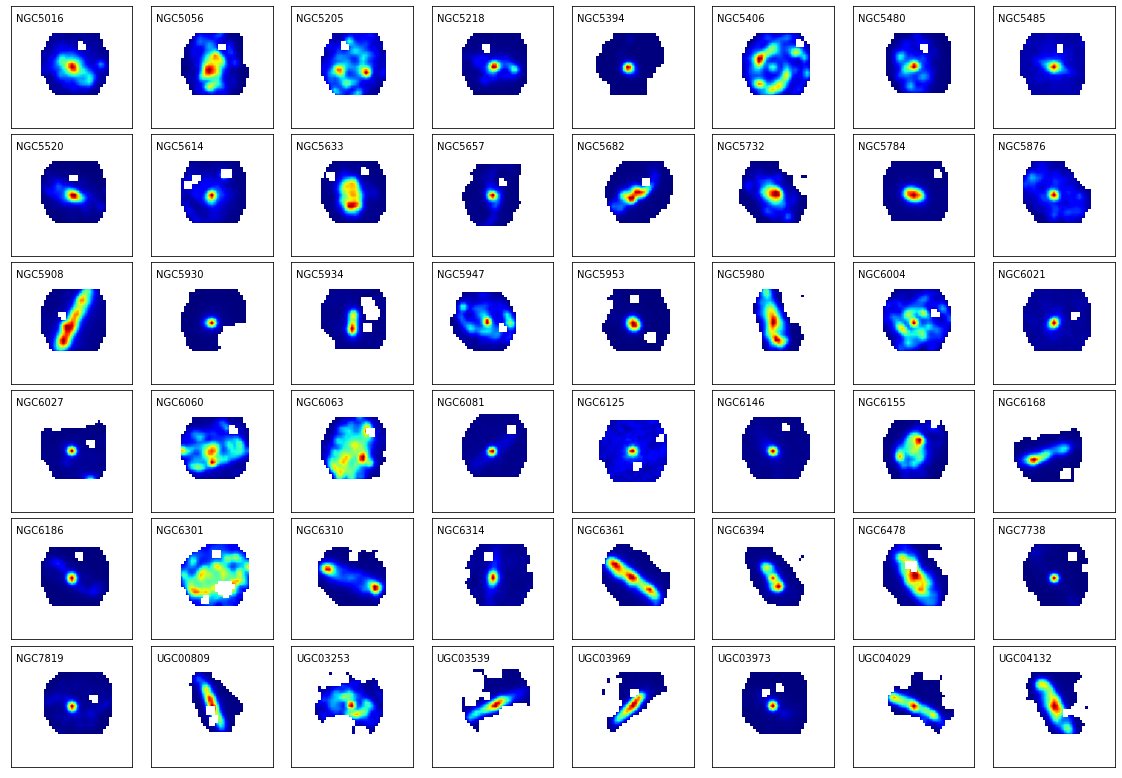

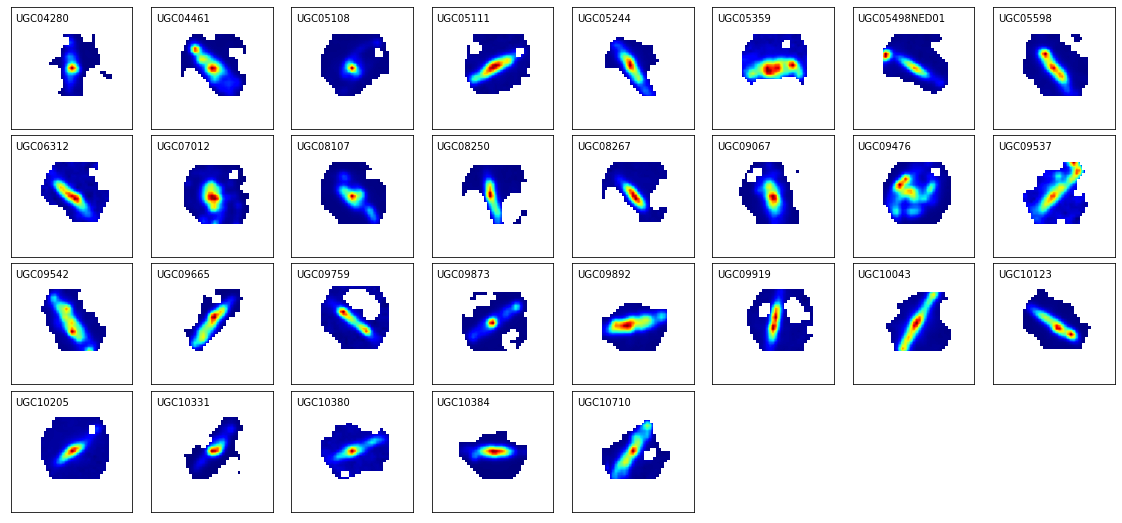

In [11]:
gallist = list(np.unique(fluxtab['Name']))
test_implots(gallist=gallist, xymin=None, xymax=None)

KeyError: 'NGC6301'